# Geographies Contained within Geographies

This notebook demonstrates how we can use the `censusdis.data.contained_within`
function to restrict our U.S. census data queries to a set of geographies contained
within another geography even if they are not a part of the same geographic hierarchy.
We will show examples of getting data at the census tract and county level within
places and CBSAs, neither or which are part of the same hierarchy as counties and 
tracts.

See `Block Groups in CBSAs.ipynb` for another example of this approach.

In [1]:
import censusdis.data as ced
import censusdis.maps as cem

from censusdis.states import NJ, KS, MO, IL
from censusdis.places.new_jersey import NEWARK_CITY
from censusdis.msa_msa import KANSAS_CITY_MO_KS_METRO_AREA
from censusdis.datasets import ACS5

from matplotlib.ticker import StrMethodFormatter

In [2]:
# This is a census variable for median household income.
# See https://api.census.gov/data/2020/acs/acs5/variables/B19013_001E.html
MEDIAN_HOUSEHOLD_INCOME_VARIABLE = "B19013_001E"

## Census Tracts in Newark, NJ

Our goal is to download the median income of each census tract in Newark, NJ. 

Note that
in the geographic hierarchy, Newark is a place, which is under a state,
whereas tracts are under counties, which are under states. We can query for
data in Newark with `state=NJ, place="51000"` or we can query for all
the tracts in New Jersey with `state=NJ, tract="*"`. 
But there is no direct way to query with `state=NJ, place=NEWARK, tract="*"`. 

This is where
`censusdis.data.contained_within` comes in. It allows us to qualify a data
download from a given set of geographise restricted to those contained in
a geography from a different part of the hierarchy.

In [3]:
gdf_newark_tracts = ced.contained_within(state=NJ, place=NEWARK_CITY).download(
    dataset=ACS5,
    vintage=2020,
    download_variables=["NAME", MEDIAN_HOUSEHOLD_INCOME_VARIABLE],
    state=NJ,
    tract="*",
    with_geometry=True,
)

In [4]:
gdf_newark_tracts.head()

,STATE,PLACE,COUNTY,TRACT,NAME,B19013_001E,geometry
0,34,51000,013,009200,"Census Tract 92, Essex County, New Jersey",27069.0,"POLYGON ((-74.17375 40.76038, -74.17212 40.762..."
1,34,51000,013,009300,"Census Tract 93, Essex County, New Jersey",40262.0,"POLYGON ((-74.17172 40.76308, -74.17134 40.763..."
2,34,51000,013,009400,"Census Tract 94, Essex County, New Jersey",46676.0,"POLYGON ((-74.17718 40.76405, -74.17507 40.768..."
3,34,51000,013,009500,"Census Tract 95, Essex County, New Jersey",57224.0,"POLYGON ((-74.17141 40.77511, -74.17237 40.775..."
4,34,51000,013,009600,"Census Tract 96, Essex County, New Jersey",34696.0,"POLYGON ((-74.16373 40.76820, -74.16279 40.770..."


To make the plot clear, let's get the geographic boundary of Newark.


In [5]:
gdf_newark = ced.download(
    dataset=ACS5,
    vintage=2020,
    download_variables=["NAME"],
    state=NJ,
    place="51000",
    with_geometry=True,
)

Now we are ready to plot. 

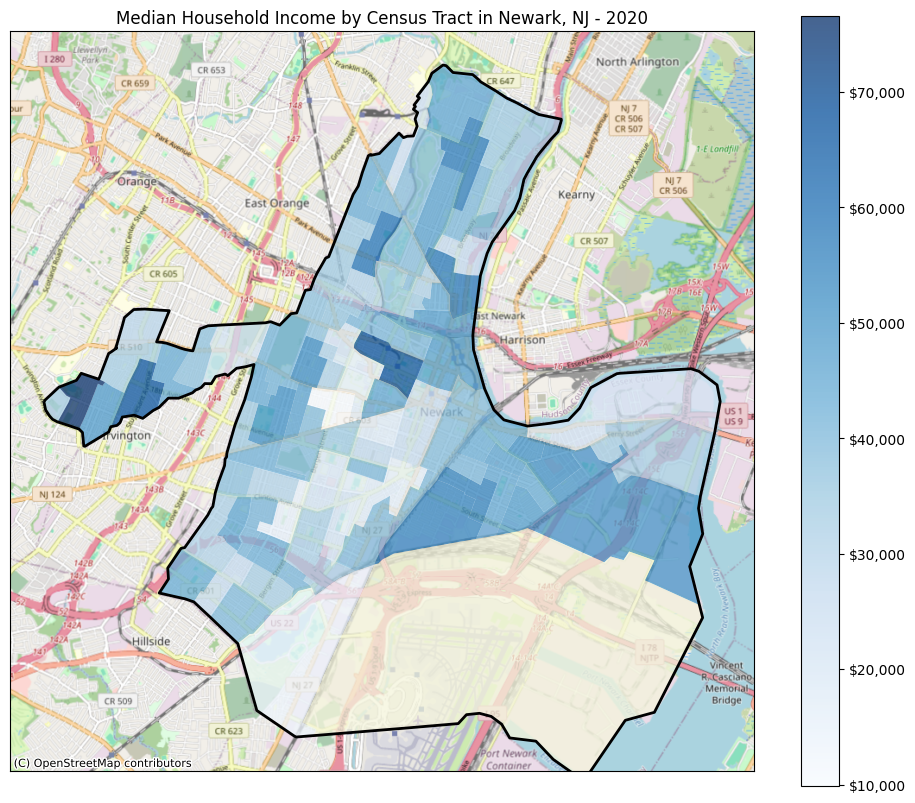

In [6]:
ax = cem.plot_map(
    gdf_newark_tracts,
    MEDIAN_HOUSEHOLD_INCOME_VARIABLE,
    cmap="Blues",
    alpha=0.75,
    with_background=True,
    figsize=(12, 10),
    legend=True,
    legend_kwds={"format": StrMethodFormatter("${x:,.0f}"), "alpha": 0.75},
)

ax = cem.plot_map(
    gdf_newark_tracts[gdf_newark_tracts[MEDIAN_HOUSEHOLD_INCOME_VARIABLE].isna()],
    color="beige",
    alpha=0.75,
    ax=ax,
)

ax = cem.plot_map(gdf_newark.boundary, color="black", linewidth=2, ax=ax)

_ = ax.set_title("Median Household Income by Census Tract in Newark, NJ - 2020")

In the plot, there is missing data in the area of the Port of Newark and
Newark Airport because these are industrial and commercial areas with no
officially counted residents.

## Counties in the Kansas City CBSA

In this example we want the same data we wanted for Newark, but for all tracts in the 
Kansas City CBSA.

Many CBSAs, a.k.a. `metropolitan_statistical_area_micropolitan_statistical_area`s, 
cross state lines. So we can't do exactly the thing we did with Newark tracts where
in the download we said `state=NJ, tract="*"`. Instead, we can just to `state="*", tract="*"`,
which means any tract in any state. This will be slower, because we have to figure out which
states intersect the geography we are using as a container, but it gets the job done. 

In [7]:
gdf_kc_tracts = ced.contained_within(
    metropolitan_statistical_area_micropolitan_statistical_area=KANSAS_CITY_MO_KS_METRO_AREA
).download(
    dataset=ACS5,
    vintage=2020,
    download_variables=["NAME", MEDIAN_HOUSEHOLD_INCOME_VARIABLE],
    state="*",
    tract="*",
    with_geometry=True,
)

In [8]:
gdf_kc_counties = ced.contained_within(
    metropolitan_statistical_area_micropolitan_statistical_area=KANSAS_CITY_MO_KS_METRO_AREA
).download(
    dataset=ACS5,
    vintage=2020,
    download_variables=["NAME"],
    state="*",
    county="*",
    with_geometry=True,
)

In [9]:
gdf_kc_counties

,METROPOLITAN_STATISTICAL_AREA_MICROPOLITAN_STATISTICAL_AREA,STATE,COUNTY,NAME,geometry
0,28140,29,037,"Cass County, Missouri","POLYGON ((-94.61270 38.48315, -94.61273 38.484..."
1,28140,29,049,"Clinton County, Missouri","POLYGON ((-94.60226 39.74719, -94.59614 39.747..."
2,28140,29,107,"Lafayette County, Missouri","POLYGON ((-94.11427 38.92854, -94.11293 38.960..."
3,28140,29,013,"Bates County, Missouri","POLYGON ((-94.61406 38.06734, -94.61396 38.109..."
4,28140,29,025,"Caldwell County, Missouri","POLYGON ((-94.20769 39.54164, -94.20739 39.570..."
5,28140,29,047,"Clay County, Missouri","POLYGON ((-94.60829 39.11794, -94.60573 39.122..."
6,28140,29,095,"Jackson County, Missouri","POLYGON ((-94.60833 38.98181, -94.60830 38.984..."
7,28140,29,165,"Platte County, Missouri","POLYGON ((-95.10141 39.53325, -95.06285 39.533..."
8,28140,29,177,"Ray County, Missouri","POLYGON ((-94.21219 39.23433, -94.21211 39.254..."
9,28140,20,091,"Johnson County, Kansas","POLYGON ((-95.05647 38.96607, -95.05626 38.982..."


In [10]:
gdf_kc = ced.download(
    dataset=ACS5,
    vintage=2020,
    download_variables=["NAME"],
    metropolitan_statistical_area_micropolitan_statistical_area=KANSAS_CITY_MO_KS_METRO_AREA,
    with_geometry=True,
)

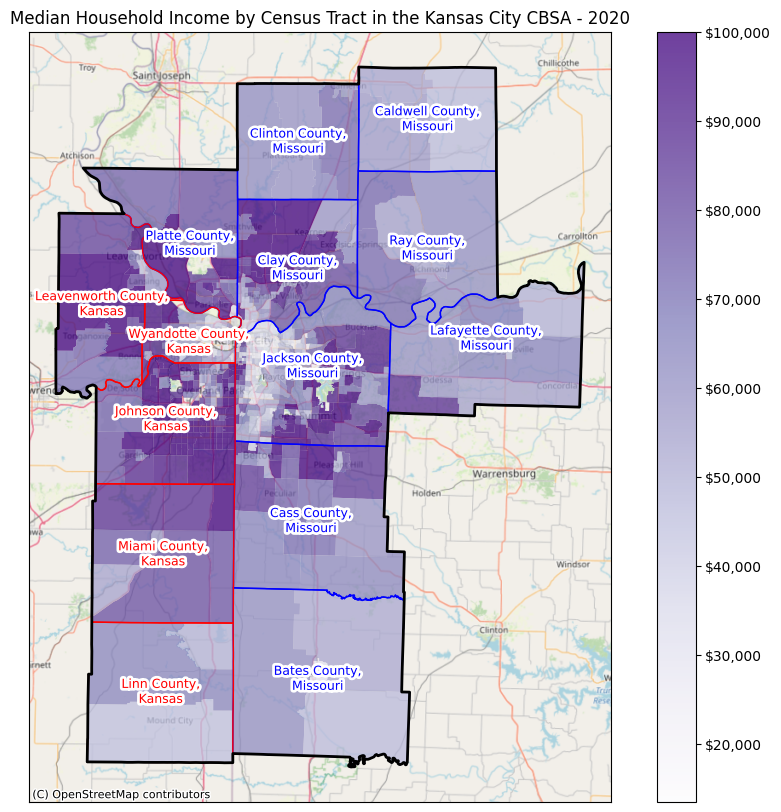

In [11]:
# Plot median income of every tract in the CBSA.
ax = cem.plot_map(
    gdf_kc_tracts,
    MEDIAN_HOUSEHOLD_INCOME_VARIABLE,
    cmap="Purples",
    vmax=100_000,
    alpha=0.75,
    with_background=True,
    figsize=(12, 10),
    legend=True,
    legend_kwds={"format": StrMethodFormatter("${x:,.0f}"), "alpha": 0.75},
)

# Format the county names for labels.
geo_label = gdf_kc_counties["NAME"].apply(lambda c: c.replace(", ", ",\n"))

# Outline MO counties in blue and name them.
ax = cem.plot_map(
    gdf_kc_counties[gdf_kc_counties["STATE"] == MO],
    edgecolor="blue",
    color="#00000000",
    linewidth=1,
    geo_label=geo_label,
    geo_label_text_kwargs={"color": "blue"},
    ax=ax,
)

# Outline KS counties in red and name them.
ax = cem.plot_map(
    gdf_kc_counties[gdf_kc_counties["STATE"] == KS],
    edgecolor="red",
    color="#00000000",
    linewidth=1,
    geo_label=geo_label,
    geo_label_text_kwargs={"color": "red"},
    ax=ax,
)

# Outline the whole CBSA in black.
ax = cem.plot_map(gdf_kc.boundary, color="black", linewidth=2, ax=ax)

_ = ax.set_title(
    "Median Household Income by Census Tract in the Kansas City CBSA - 2020"
)

## Urban Tracts in Illinois

In this example, we want to get all the census tracts that are in *any*
Combined Statistical Area (CSA) in the state of Illinois.

In [12]:
gdf_il_urban_tracts = ced.contained_within(
    # Must be in a CSA, but it can be any CSA in the country.
    combined_statistical_area="*"
).download(
    dataset=ACS5,
    vintage=2020,
    download_variables=["NAME"],
    # Must be in IL
    state=IL,
    # Can be any tract.
    tract="*",
    with_geometry=True,
)

In [13]:
gdf_il_urban_tracts.head()

,COMBINED_STATISTICAL_AREA,STATE,COUNTY,TRACT,NAME,geometry
0,176,17,031,251000,"Census Tract 2510, Cook County, Illinois","POLYGON ((-87.74842 41.90233, -87.74658 41.902..."
1,176,17,031,251100,"Census Tract 2511, Cook County, Illinois","POLYGON ((-87.75577 41.90225, -87.75333 41.902..."
2,176,17,031,251200,"Census Tract 2512, Cook County, Illinois","POLYGON ((-87.76565 41.90214, -87.76382 41.902..."
3,176,17,031,251300,"Census Tract 2513, Cook County, Illinois","POLYGON ((-87.77536 41.90200, -87.77294 41.902..."
4,176,17,031,251400,"Census Tract 2514, Cook County, Illinois","POLYGON ((-87.77513 41.89471, -87.77229 41.894..."


In [14]:
# Get the outline of the whole state for mapping purposes.
gdf_il = ced.download(
    dataset=ACS5,
    vintage=2020,
    download_variables=["NAME"],
    state=IL,
    with_geometry=True,
)

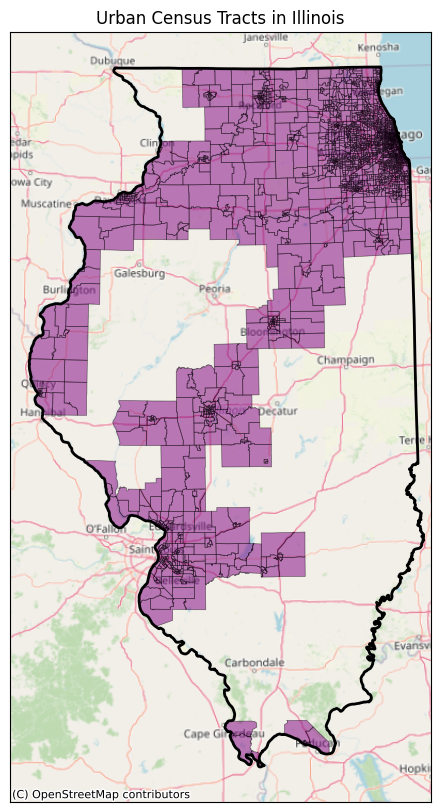

In [15]:
ax = cem.plot_map(
    gdf_il_urban_tracts,
    color="purple",
    edgecolor="black",
    linewidth=0.5,
    alpha=0.5,
    with_background=True,
    figsize=(6, 10),
)

ax = cem.plot_map(gdf_il.boundary, edgecolor="black", linewidth=2, ax=ax)

_ = ax.set_title("Urban Census Tracts in Illinois")